<a href="https://colab.research.google.com/github/SergeiSa/Control-Theory-Slides-Spring-2021/blob/main/ColabNotebooks/practice_13_design_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practice 13: Design Example, Orbital maneuver**

---

### **Problem Definition:**

Consider a satellite described by the following equations:
\begin{equation}
\left\{\begin{matrix}
m\ddot{r}=m r\dot{\theta}^2  -G\cfrac{m M}{r^2} + u_r
\\ 
mr\ddot{\theta}=-2 m \dot{r}\dot{\theta}+ u_\theta
\end{matrix}\right.
\end{equation}

A problem is to **stabilize** the satellite on the desired orbit of constant radius $r_d = \text{const}$ with minimal control effort. 




<p><img alt="linear mapping" height="450px" src="https://drive.google.com/uc?id=1yvtXC__pJRka_DaK1KKolVcgzu9uo8WF" align="center" hspace="250px" vspace="0px"></p>





The overall workflow to design the controller is summarized as follows:


1.   Modeling, **State space representation** of system dynamics ( [Practice 1](https://colab.research.google.com/drive/1OE18rhr8Mhq3H5FS5yci037CQ52ag4yq))
2.   Deducing **feasible trajectory** 
3.   **Linearizing** system dynamics nearby desired trajectory, **linear state space** ( [Practice 8](https://colab.research.google.com/drive/15l9Pyv-ol33NrwM3v48r9jjZLP_Vgimt)) 
4.   **Discretization** of linearized system ( [Practice 6](https://colab.research.google.com/drive/1FLxfvWfwhNvjlYz-9oQJviwlj9M0URUh))
5.   **Controllability** analysis ( [Practice 11](https://colab.research.google.com/drive/1Rs_RygP56Fea_Y_QDGIl8vAy4Ht_wkSM))
6.   **Сontroller** design ( [Practice 9](https://colab.research.google.com/drive/1_MjEdyWbJ2In3NZRfdrmKUPdR0IobKH-))



In order to check the designed controller we will implement the following simulations:
1.   Full state feedback on the **linearized** system 
2.   Full state feedback on the **original** system 




### **State Space Representation**

Let us first introduce the following constant $k = gM$ and rewrite system dynamics in normal form: 
\begin{equation}
\left\{\begin{matrix}
\ddot{r}= r\dot{\theta}^2  -\cfrac{k}{r^2} + \cfrac{u_r}{m}
\\ 
\ddot{\theta}=-2 \cfrac{\dot{r}\dot{\theta}}{r}+ \cfrac{u_\theta}{mr}
\end{matrix}\right.
\end{equation}

Thus introducing the state variables as $\mathbf{x} = [r, \dot{r}, \theta, \dot{\theta}]^T$ we may rewrite the equiations above in state space form:

\begin{equation}
\begin{bmatrix}
\dot{\mathbf{x}}_1 
\\
\dot{\mathbf{x}}_2
\\
\dot{\mathbf{x}}_3
\\ 
\dot{\mathbf{x}}_4
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{x}_2 
\\
\mathbf{x}_1 \mathbf{x}_4^2
\\
\mathbf{x}_4
\\ 
-2 \cfrac{\mathbf{x}_2\mathbf{x}_4}{\mathbf{x}_1}
\end{bmatrix}
+
\begin{bmatrix}
 0 & 0 \\
  -\frac{1}{m} & 0 \\
 0 & 0 \\
 0 & \frac{1}{m \mathbf{x}_1}\\
\end{bmatrix}
\begin{bmatrix}
u_r
\\
u_\theta
\end{bmatrix}
\end{equation}

Which may be written in general state space form as:


\begin{equation}
\dot{\mathbf{x}}
= 
\mathbf{f}(\mathbf{x}, \mathbf{u})
\end{equation}


In [ ]:
def f(x, u, params):
    k, m = params
    r, dr, theta, dtheta = x
    u_r, u_theta = u
    ddr = r*dtheta**2 -k/(r**2) + u_r/m  
    ddtheta = -2*dr*dtheta/r + u_theta/(r*m)
    return dr, ddr, dtheta, ddtheta

import sympy as sym

sym.init_printing()

x_sym = sym.symbols(r'r \dot{r} \theta \dot{\theta}') 
u_sym = sym.symbols(r'u_r u_\theta') 
params_sym = sym.symbols(r'k m')
f_sym = sym.Matrix([f(x_sym, u_sym, params_sym)]).T

f_sym


⎡              \dot{r}              ⎤
⎢                                   ⎥
⎢                 2     k    uᵣ     ⎥
⎢     \dot{\theta} ⋅r - ── + ──     ⎥
⎢                        2   m      ⎥
⎢                       r           ⎥
⎢                                   ⎥
⎢           \dot{\theta}            ⎥
⎢                                   ⎥
⎢  2⋅\dot{\theta}⋅\dot{r}   u_\theta⎥
⎢- ────────────────────── + ────────⎥
⎣            r                m⋅r   ⎦

### **Feasible trajectory: Equatorial orbit**
Once model is given by the state space representation above we may obtain trajectory that is consistent with dynamics by direct substitution of the constant $r_d = \text{const}$:
\begin{equation}
\left\{\begin{matrix}
0= r_d\dot{\theta}_d^2  -\cfrac{k}{r_d^2} + \cfrac{u_{r_d}}{m}
\\ 
\ddot{\theta}_d= \cfrac{u_{\theta_d}}{mr_d}
\end{matrix}\right.
\end{equation}

Moreover if one will consider effortless ($u_{r_d}, u_{\theta_d}$) trajectories the equations above represent the following: 

\begin{equation}
r^3_d \dot{\theta}_d^2  = k \rightarrow \dot{\theta}_d = \omega = \sqrt{\frac{k}{r^3_d}}{}
\end{equation}
 Thus the desired trajectory is given by following state/control pair:
\begin{equation}
\mathbf{x}_d = 
\begin{bmatrix}
r_d & 0 &  \omega t & \omega
\end{bmatrix}^T
\\
\mathbf{u}_d =  
\begin{bmatrix}
u_{\theta_d} & u_{r_d}
\end{bmatrix}^T
=
\begin{bmatrix}
0 & 0
\end{bmatrix}^T
\end{equation}
Thus the solution is flies along the line of the Earth's equator with constant speed and represent so called equatorial orbit. 

***Note***

To get into equatorial orbit, a satellite must be launched from a place on Earth close to the equator. NASA often launches satellites aboard an Ariane rocket into equatorial orbit from French Guyana. Special case of equatorial orbit is a geosynchronous (sometimes abbreviated GSO) is an orbit around Earth of a satellite with an orbital period that matches Earth's rotation on its axis, which takes one sidereal day (23 hours, 56 minutes, and 4 seconds) 

### **Linearization**
System above is nonlinear, in order to implement the techniques that we studied in this class we need to first obtain the linear state space model. A convinient way to do so is to linearize system dynamics nearby equilibrium point or desired trajectory:

\begin{equation}
\dot{\mathbf{x}}
= \mathbf{f}(\mathbf{x}_d,\mathbf{u}_d)+ 
\frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d} 
(\mathbf{x} - \mathbf{x}_d) + 
\frac{\partial\mathbf{u}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}  
(\mathbf{u} - \mathbf{u}_d)  + \text{H.O.T}
\end{equation}

Introducing the tracking error $\tilde{\mathbf{x}}$ we may rewrite the equation above in linear form as follows:

\begin{equation}
\dot{\tilde{\mathbf{x}}} = \mathbf{A}\tilde{\mathbf{x}} + \mathbf{B}\tilde{\mathbf{u}}   
\end{equation}
where: $\tilde{\mathbf{x}}$ is tracking error, $\tilde{\mathbf{u}}$ is the new control input $\mathbf{A} = \frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$ - state evaluation matrix, $\mathbf{B} = \frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


Let us first calculate system jacobian with respect to state: $\frac{\partial\mathbf{f}}{\partial\mathbf{x}}$


In [ ]:
# Calculate the jacobian with respect to x
Jx_sym = f_sym.jacobian(x_sym)
Jx_sym


⎡                0                         1          0         0        ⎤
⎢                                                                        ⎥
⎢                   2   2⋅k                                              ⎥
⎢       \dot{\theta}  + ───                0          0  2⋅\dot{\theta}⋅r⎥
⎢                         3                                              ⎥
⎢                        r                                               ⎥
⎢                                                                        ⎥
⎢                0                         0          0         1        ⎥
⎢                                                                        ⎥
⎢2⋅\dot{\theta}⋅\dot{r}   u_\theta  -2⋅\dot{\theta}        -2⋅\dot{r}    ⎥
⎢────────────────────── - ────────  ────────────────  0    ───────────   ⎥
⎢           2                  2           r                    r        ⎥
⎣          r                m⋅r                                          ⎦


Now we can evaluate the jacobian nearby desired trajectory $\mathbf{A} = \frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


In [ ]:
# Evaluate J_x nearby desired trajectory
n = len(x_sym)
A_sym = Jx_sym


A_sym = A_sym.subs({x_sym[0]: 'r_d'})
A_sym = A_sym.subs({x_sym[1]: 0})
A_sym = A_sym.subs({x_sym[3]: sym.symbols(r'\omega')})
A_sym = A_sym.subs({u_sym[1]: 0})

A_sym.simplify()
A_sym

⎡      0             1       0       0      ⎤
⎢                                           ⎥
⎢      2   2⋅k                              ⎥
⎢\omega  + ────      0       0  2⋅\omega⋅r_d⎥
⎢             3                             ⎥
⎢          r_d                              ⎥
⎢                                           ⎥
⎢      0             0       0       1      ⎥
⎢                                           ⎥
⎢                -2⋅\omega                  ⎥
⎢      0         ──────────  0       0      ⎥
⎣                   r_d                     ⎦

System jacobian with respect to control: $\frac{\partial\mathbf{f}}{\partial\mathbf{u}}$


In [ ]:
# calculate the jacobian with respect to u
Ju_sym = f_sym.jacobian(u_sym)
Ju_sym

⎡0   0 ⎤
⎢      ⎥
⎢1     ⎥
⎢─   0 ⎥
⎢m     ⎥
⎢      ⎥
⎢0   0 ⎥
⎢      ⎥
⎢    1 ⎥
⎢0  ───⎥
⎣   m⋅r⎦

Now we may substitude the desired trajectory $\mathbf{B} = \frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


In [ ]:
B_sym = Ju_sym.subs(x_sym[0], 'r_d')
B_sym

⎡0    0  ⎤
⎢        ⎥
⎢1       ⎥
⎢─    0  ⎥
⎢m       ⎥
⎢        ⎥
⎢0    0  ⎥
⎢        ⎥
⎢     1  ⎥
⎢0  ─────⎥
⎣   m⋅r_d⎦

### **Similarity Transformation**

There are situations when system matrices are not well defined in several directions, it may happen for instance when the variables to control represent a physical quantities that are highly different in their magnitudes, thus resulting system (matrices $\mathbf{A}, \mathbf{B}$) will be barely controllable. To tackle this one may appropriately scale the state variables with some matrix $\mathbf{T}$ as follows:
\begin{equation}
\mathbf{x}^* = \mathbf{T}\mathbf{x}
\end{equation}

Thus the state transition may be calculated by substitution of the $\mathbf{x} = \mathbf{T}^{-1}\mathbf{x}^*$ to the system dynamics:
\begin{equation}
\dot{\mathbf{x}}^* = \mathbf{A}^*\mathbf{x}^* + \mathbf{B}^*\mathbf{u}
\end{equation}
\begin{equation}
\mathbf{y}^* = \mathbf{C}^*\mathbf{x}^*
\end{equation}

where matrices $\mathbf{A}^* = \mathbf{T}\mathbf{A}\mathbf{T}^{-1}, \mathbf{B}^* = \mathbf{T}\mathbf{B}, \mathbf{C}^* = \mathbf{C}\mathbf{T}^{-1}$

Note that the control input do not changed, thus we can design the controller in terms of new state $\mathbf{x}^*$ and then apply the resulting controller directly to the original variables $\mathbf{x}$

Let us choose the following transformation:


In [ ]:
T_sym = sym.matrices.zeros(4)
T_sym = T_sym.diag([1, 1, 'r_d', 'r_d'])
T_sym

⎡1  0   0    0 ⎤
⎢              ⎥
⎢0  1   0    0 ⎥
⎢              ⎥
⎢0  0  r_d   0 ⎥
⎢              ⎥
⎣0  0   0   r_d⎦

In [ ]:
As_sym = T_sym*A_sym*T_sym.inv()
As_sym

⎡      0             1      0     0    ⎤
⎢                                      ⎥
⎢      2   2⋅k                         ⎥
⎢\omega  + ────      0      0  2⋅\omega⎥
⎢             3                        ⎥
⎢          r_d                         ⎥
⎢                                      ⎥
⎢      0             0      0     1    ⎥
⎢                                      ⎥
⎣      0         -2⋅\omega  0     0    ⎦

In [ ]:
Bs_sym = T_sym*B_sym
Bs_sym

⎡0  0⎤
⎢    ⎥
⎢1   ⎥
⎢─  0⎥
⎢m   ⎥
⎢    ⎥
⎢0  0⎥
⎢    ⎥
⎢   1⎥
⎢0  ─⎥
⎣   m⎦

Let's now create the numerical representation of system matrices as follows:

In [ ]:
import numpy as np

re =	6371e+3
r_d = re + 35e6

m = 200
G = 6.67408e-11
M = 5.972e+24
k = G*M
omega = np.sqrt(k/r_d**3)

A = np.array(As_sym.subs({'r_d':r_d, 'k':k, '\omega':omega}), dtype = 'double')
B = np.array(Bs_sym.subs({'m':m}), dtype = 'double')
print(A)


[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.68866852e-08  0.00000000e+00  0.00000000e+00  1.50051925e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -1.50051925e-04  0.00000000e+00  0.00000000e+00]]


### **Discretization**
In practice the control is implemented in digital fashion, thus in order to design the control, system dynamics must be discretized and be presented in the form:

\begin{equation}
{\mathbf  {x}}[k+1]={\mathbf  A}_{d}{\mathbf  {x}}[k]+{\mathbf  B}_{d}{\mathbf  {u}}[k]
\end{equation}

In order to descretize system exactly, one just need to solve it on time interval $T$ (sampling time):

\begin{equation}
{\mathbf  A}_{d}=e^{{{\mathbf  A}T}}={\mathcal  {L}}^{{-1}}\{(s{\mathbf  I}-{\mathbf  A})^{{-1}}\}_{{t=T}}
\\
{\mathbf  B}_{d}=\left(\int _{{\tau =0}}^{{T}}e^{{{\mathbf  A}\tau }}d\tau \right){\mathbf  B}={\mathbf  A}^{{-1}}({\mathbf  A}_{d}-I){\mathbf  B}
\end{equation}

Let us find the discrete representation of system dynamics with samplng time $T = 10$ s

In [ ]:
from scipy.signal import cont2discrete

C = np.array([[1, 0, 0 ,0]])
D = np.array([[0, 0]])

dT = 10

B_r = np.array([B[:,0]]).T
B_theta = np.array([B[:,1]]).T

A_d, B_d, C_d, D_d, _ = cont2discrete((A,B,C,D), dT)
_, B_theta_d, _, _, _ = cont2discrete((A,B_theta,C,D), dT)
_, B_r_d, _, _, _ = cont2discrete((A,B_r,C,D), dT)

print(f"Exact discretization:\n {A_d, B_d}")

Exact discretization:
 (array([[ 1.00000084e+00,  9.99999906e+00,  0.00000000e+00,
         7.50259590e-03],
       [ 1.68866836e-07,  9.99999719e-01,  0.00000000e+00,
         1.50051911e-03],
       [-4.22313257e-10, -7.50259590e-03,  1.00000000e+00,
         9.99999625e+00],
       [-1.26693975e-10, -1.50051911e-03,  0.00000000e+00,
         9.99998874e-01]]), array([[ 2.49999988e-01,  1.25043267e-04],
       [ 4.99999953e-02,  3.75129795e-05],
       [-1.25043267e-04,  2.49999953e-01],
       [-3.75129795e-05,  4.99999812e-02]]))


### **Controlability**


In [ ]:
def ctrb(A, B):
  R = B
  n = np.shape(A)[0]
  for i in range(1,n):
    A_pwr_n = np.linalg.matrix_power(A, i)
    R = np.hstack((R,A_pwr_n.dot(B)))
    rank_R = np.linalg.matrix_rank(R)
  
  if rank_R == n:
    test = 'controllable'
  else:
    test = 'uncontrollable'
  return R, rank_R, test

Let us check the contrallability condition using both of the control channels  
$u_r, u_\theta$ and each of them separately:


In [ ]:
for B_matrix in B_r_d, B_theta_d, B_d:
  R, rank, test = ctrb(A_d, B_matrix)
  print(f'\nRank of the controlability matrix: {rank},\nsystem is {test}' )


Rank of the controlability matrix: 3,
system is uncontrollable

Rank of the controlability matrix: 4,
system is controllable

Rank of the controlability matrix: 4,
system is controllable


Thus the system is controllable just with the one input, physically it represent the thrust vector pointing in tangent line: $u_\theta$  

Recall that one can use the Popov-Belevitch-Hautus test to do the same. 

In [ ]:
def pbh(A, B):
    lambdas, v = np.linalg.eig(A)
    n = np.shape(A)[0]
    ranks = n*[0]
    # M = n*[0]
    test = 'controllable'
    for i in range(n):
      M = np.hstack((A - lambdas[i]*np.eye(n), B))
      ranks[i] = np.linalg.matrix_rank(M)
      if ranks[i] != n:
        test = 'uncontrollable'
        if np.real(lambdas[i])<0:
          test += ' but stabilizable'
    return ranks, lambdas, test



eigs, ranks, test = pbh(A_d,B_r_d)
print(f'Eigen values of PBH matrices:\n{eigs}\n\nRanks of the PBH matrices: {ranks},\nsystem is {test}' )

eigs, ranks, test = pbh(A_d,B_theta_d)
print(f'Eigen values of PBH matrices:\n{eigs}\n\nRanks of the PBH matrices: {ranks},\nsystem is {test}' )

Eigen values of PBH matrices:
[3, 4, 4, 3]

Ranks of the PBH matrices: [1.        +0.j         0.99999972+0.00075026j 0.99999972-0.00075026j
 1.        +0.j        ],
system is uncontrollable
Eigen values of PBH matrices:
[4, 4, 4, 4]

Ranks of the PBH matrices: [1.        +0.j         0.99999972+0.00075026j 0.99999972-0.00075026j
 1.        +0.j        ],
system is controllable


The number of necesarry control channels may be deduced by analyzing the rank of "PBH matrices"

In [ ]:
lambdas, v = np.linalg.eig(A_d)
n = len(lambdas)

for i in range(n):
  A_e = A_d - lambdas[i]*np.eye(n)
  print(f'Eigenvalue s: {lambdas[i]}')
  print(f'Rank of A - sI: {np.linalg.matrix_rank(A_e)}')
  print(f'Rank difficiency: {n - np.linalg.matrix_rank(A_e)}\n')

Eigenvalue s: (1+0j)
Rank of A - sI: 3
Rank difficiency: 1

Eigenvalue s: (0.9999997185552608+0.0007502595547439014j)
Rank of A - sI: 3
Rank difficiency: 1

Eigenvalue s: (0.9999997185552608-0.0007502595547439014j)
Rank of A - sI: 3
Rank difficiency: 1

Eigenvalue s: (1.0000000000000002+0j)
Rank of A - sI: 3
Rank difficiency: 1



Since the matrices are of rank 3 - we need the only one actuator to control this system. However, for this practice lets use both of them. 

### **Discrete Time LQR**
For a discrete-time linear system described by:

\begin{equation}
\mathbf{x}_{k+1}=\mathbf{A} \mathbf{x}_{k}+\mathbf{B}\mathbf{u}_{k}
\end{equation}
with a performance index defined as:
\begin{equation}
J_c=\sum \limits _{{k=0}}^{{\infty }}\left(\mathbf{x}_{k}^{T}\mathbf{Q}\mathbf{x}_{k}+\mathbf{u}_{k}^{T}\mathbf{R}\mathbf{u}_{k}\right)
\end{equation}

the optimal control sequence minimizing the performance index is given by:
\begin{equation}
\mathbf{u}_{k}=-\mathbf{K} \mathbf{x}_{k}
\end{equation}

where:
\begin{equation}
\mathbf{K}=(\mathbf{R}+\mathbf{B}^{T}\mathbf{S}\mathbf{B})^{{-1}}\mathbf{B}^{T}\mathbf{S}\mathbf{A}
\end{equation}

and $\mathbf{S}$ is the unique positive definite solution to the discrete time algebraic Riccati equation (DARE):

\begin{equation}
\mathbf{S}=\mathbf{A}^{T}\mathbf{S}\mathbf{A}-(\mathbf{A}^{T}\mathbf{S}\mathbf{B})\left(\mathbf{R}+\mathbf{B}^{T}\mathbf{S}\mathbf{B}\right)^{{-1}}(\mathbf{B}^{T}\mathbf{S}\mathbf{A})+\mathbf{Q}
\end{equation}

In [ ]:
from scipy.linalg import solve_discrete_are as dare

def dlqr(A, B, Q, R):
    # Solve the DARE
    S = dare(A, B, Q, R)
    R_inv = np.linalg.inv(R + B.T @ S @ B )
    K = R_inv @ (B.T @ S @ A)
    Ac = A - B.dot(K)
    E = np.linalg.eigvals(Ac)
    return S, K, E


Let us find the descrete LQR gain that minimize the cost above while highly penelazing the thrust vector: 

In [ ]:
Q = np.diag([0.1,0.1,0.00001,0.01])

R = np.diag([10000000, 1000000])

S, Kd, E = dlqr(A_d, B_d, Q, R)

 ### **Simulation**

As for now we find the controller to be:

\begin{equation}
\mathbf{u}_{k}=-\mathbf{K} \mathbf{x}_{k}
\end{equation}

Let us simulate the controller on two systems:

1.   Linear discrete system:
\begin{equation}
\mathbf{x}_{k+1}=\mathbf{A} \mathbf{x}_{k}+\mathbf{B}\mathbf{u}_{k}
\end{equation}

2.   Nonlinear continues system, solved on discrete time instances (discrete control, continues dynamics):
\begin{equation}
\mathbf{x}_{k+1}=\int_{t_k}^{t_k + dT} \mathbf{f}(\mathbf{x}(\tau),\mathbf{u}_k) d\tau 
\end{equation}




 #### **Linear Case**


We will assume that the initial orbit is $5000$ km above desired one:

In [ ]:
r_0 = r_d + 5e6

Let us first choose the initial orbit that $5000$ km far from the desired one:

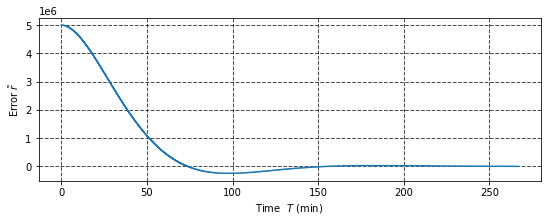

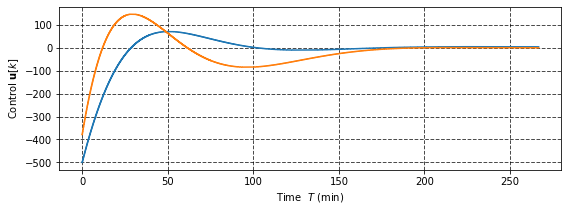

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 1600
x = np.array([ r_0 - r_d,0, 0, 0])
X = x
U = -Kd@x

for k in range(N):
  u = -Kd@x 
  x = A_d @ x + B_d @ u
  X = np.vstack((X, x))
  U = np.vstack((U, u))

e_r_d, e_dr_d, e_theta_d, e_dtheta_d = np.split(X, 4, axis = 1)


t = np.array(range(N+1))*dT/60

plt.figure(figsize=(9, 3))
plt.step(t,e_r_d)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Error $\tilde{r}$')
plt.xlabel(r'Time  $T$ (min)')
plt.show()

plt.figure(figsize=(9, 3))
plt.step(t,U)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Control $\mathbf{u}[k]$')
plt.xlabel(r'Time  $T$ (min)')
plt.show()

 #### **Nonlinear Case**


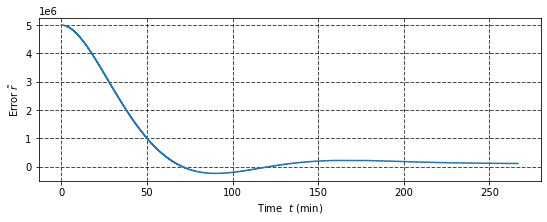

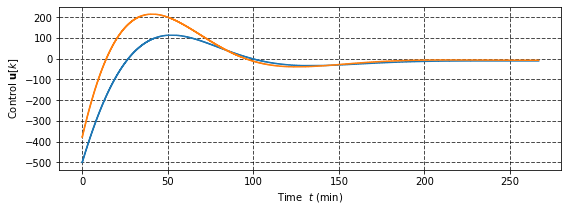

In [ ]:
from scipy.integrate import odeint

params = k, m

func = lambda x, t, u, params : f(x, u, params)

x0 = np.array([r_0, 0, 0, 0])
T_span = np.linspace(0, dT, 5)
X = x0

x_d = np.array([r_d, 0, 0, omega])
e = x0 - x_d 
E = e
U = -Kd@e

for k in range(N):
  t = k*dT
  x_d = np.array([r_d, 0, omega*t, omega])
  e = x0 - x_d 
  u = -Kd@e
  x_sol = odeint(func, x0, T_span, args=(u, params,))
  x0 = x_sol[-1]

  X = np.vstack((X, x0))
  E = np.vstack((E, e))
  U = np.vstack((U, u))

r, dr, theta, dtheta = np.split(X, 4, axis = 1)
e_r, e_dr, e_theta, e_dtheta = np.split(E, 4, axis = 1)
t = np.array(range(N+1))*dT/60

plt.figure(figsize=(9, 3))
plt.step(t,e_r)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Error $\tilde{r}$')
plt.xlabel(r'Time  $t$ (min)')
plt.show()

plt.figure(figsize=(9, 3))
plt.step(t,U)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Control $\mathbf{u}[k]$')
plt.xlabel(r'Time  $t$ (min)')
plt.show()

We can compare the response:

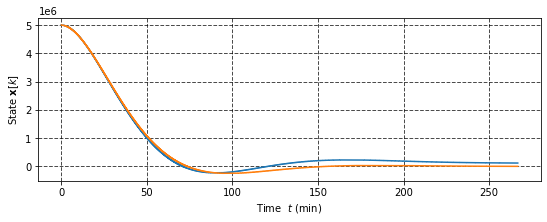

In [ ]:
plt.figure(figsize=(9, 3))
plt.step(t,e_r)
plt.step(t,e_r_d)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'State $\mathbf{x}[k]$')
plt.xlabel(r'Time  $t$ (min)')
plt.show()


### **HW Problem:**

Check if it is possible to use either $r$ or $\theta$ to design controller, if it's so design the observer to estimate the full state $\mathbf{\hat{x}}$ and then use the estimated state for full state feedback $\mathbf{u}_k = -\mathbf{K}\mathbf{\hat{x}}_k$. Simulate the designed controller both on linear and nonlinear systems.
